Note: daylight saving in month 3 and 10 => drop these two

In [1]:
import math, random, pickle, os, copy, itertools, sys
import torch, logging, scipy.io
import numpy as np
import pandas as pd
from numpy import random
from datetime import datetime
import matplotlib.pyplot as plt
from collections.abc import Iterable

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from house_pv import HousePV
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


/home/mahrokhg/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Selecting the month
* data within this month should be homogeneous
* group month of the same year (do we need to train different models for different groups of months? for which ones?)
* which month are harder to predict?
* compare with another year (train and test must come from the same dist)

In [2]:
from weather_station import WeatherStation

#Reading the data file: DOWNLOAD DATA FROM PVGIS USING TILT=0 i.e. DATA OF IRRADIANCE ON NORMAL PLANE
city_name = 'Lausanne'
weather_station = WeatherStation(city_name)

house = HousePV(tilt=0, azimuth=180,
                module_name='Canadian_Solar_CS5P_220M___2009_',
                inverter_name='ABB__MICRO_0_25_I_OUTD_US_208__208V_',
                latitude=45.473, longitude=9.185, altitude=133,
                weather_dev=0, irrad_scale=1,
                weather_station=weather_station,
                shadows={'st':None, 'en':None, 'peak_red':1},
                random_state=None)

house.simulate_pv()
house.construct_regression_df(
                use_station_irrad_direct=True, use_station_irrad_diffuse=True,
                delay_irrad=True, lags=[1], hours=np.arange(8,18),
                months=np.arange(1, 13), step_ahead=1)
(X_train, y_train, X_valid, y_valid) = house.construct_regression_matrices(
                m_train=None, train_years=[2019], valid_years=2020)

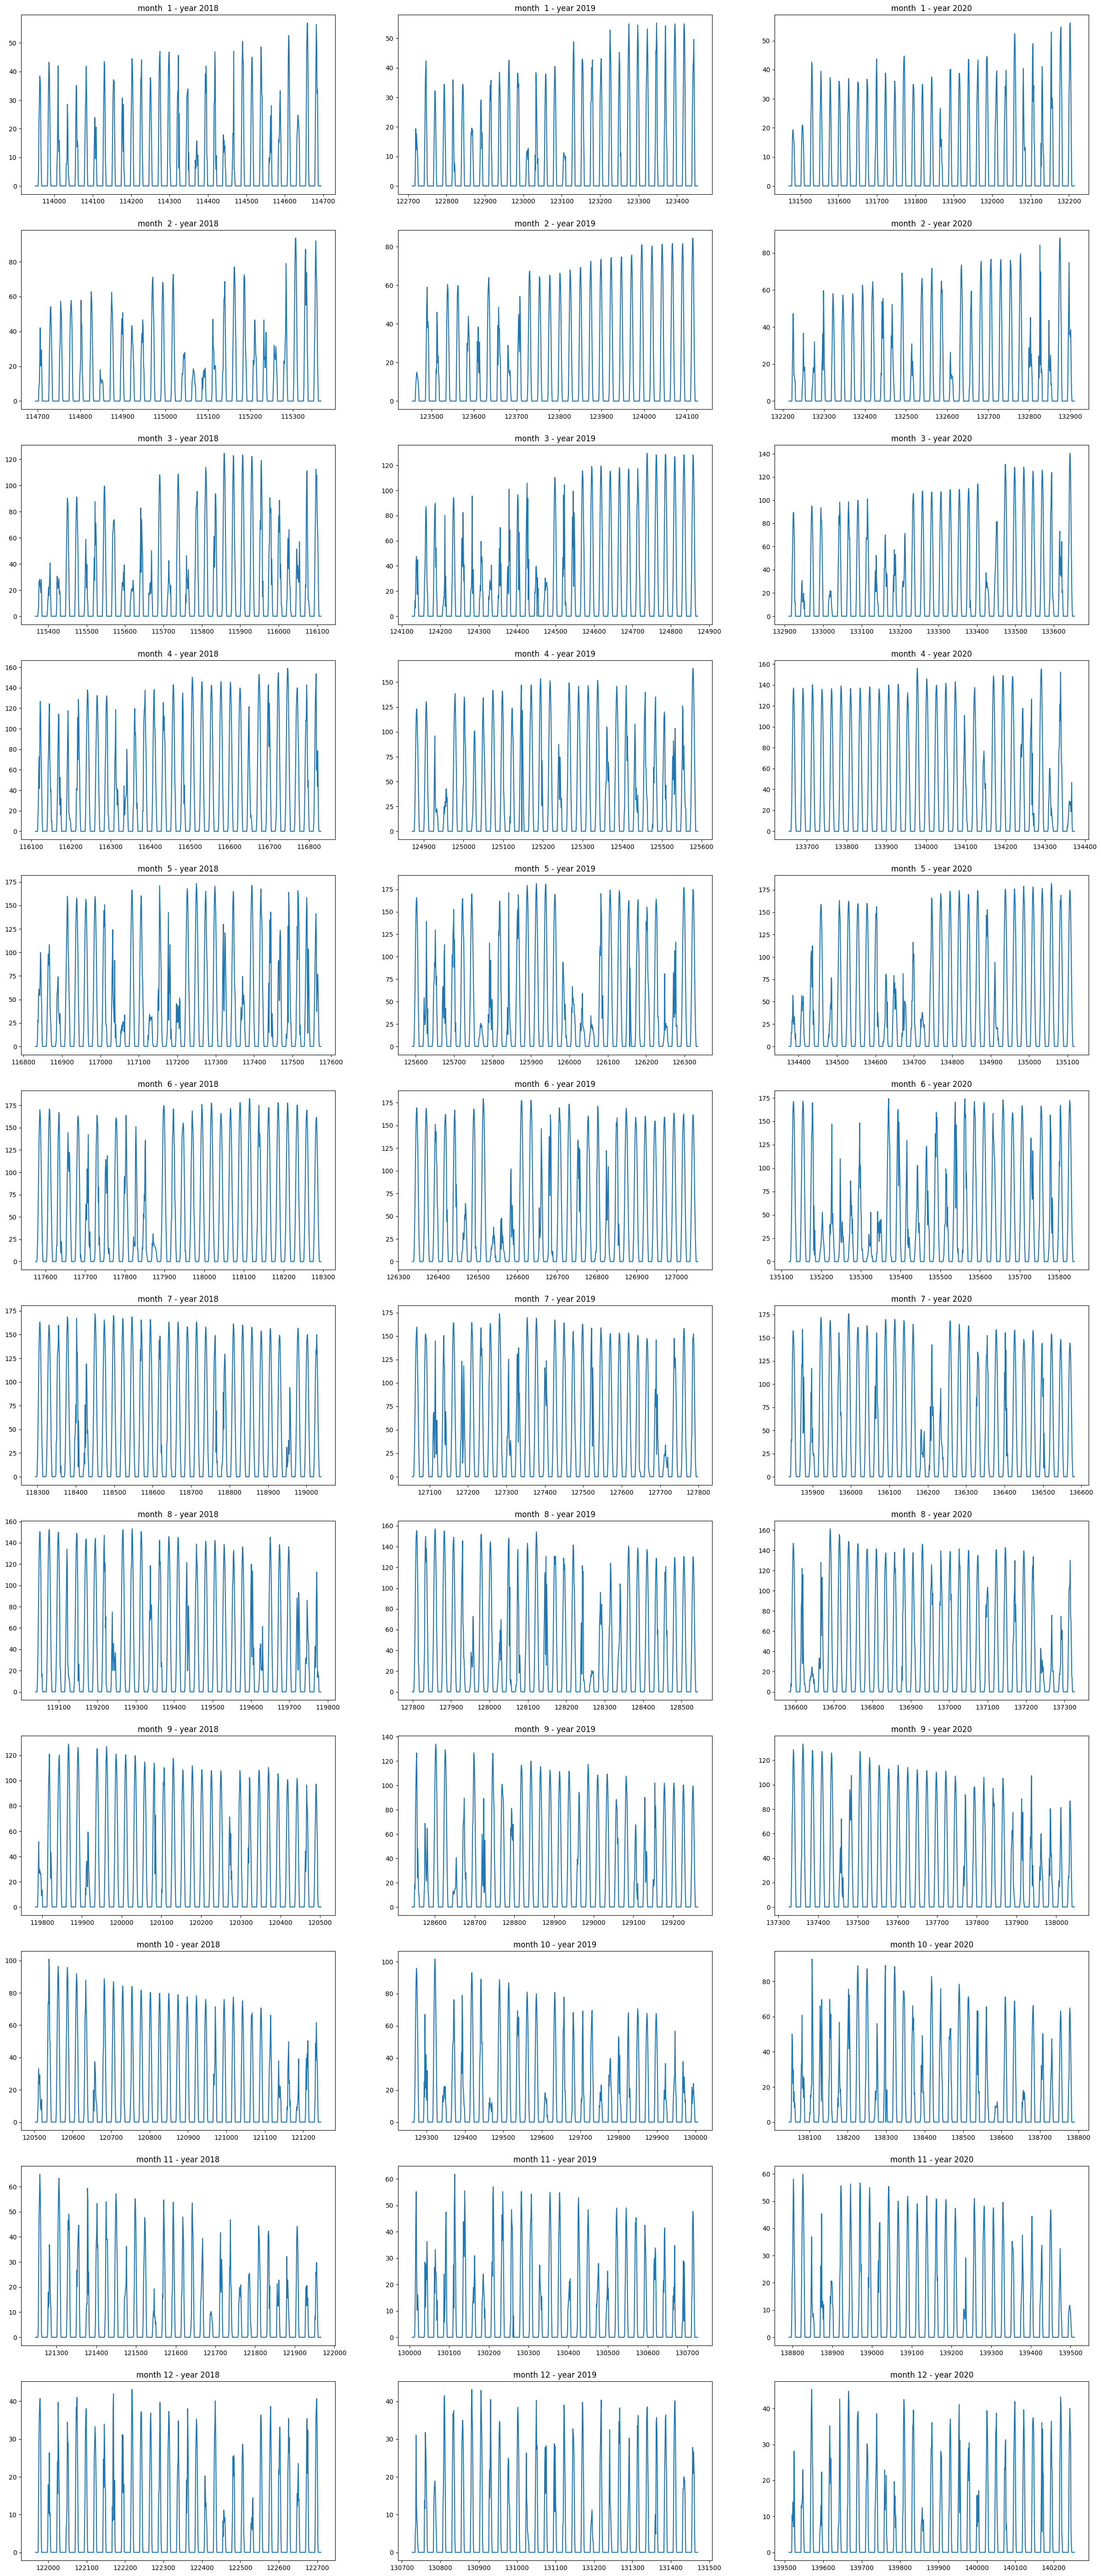

In [3]:
plot_year = [2018, 2019, 2020]
fig, axs = plt.subplots(12, len(plot_year), figsize = (30, 6*12))
for month_ind in np.arange(12):
    for year_ind in np.arange(len(plot_year)):
        if len(plot_year) == 1:
            ax = axs[month_ind]
        else:
            ax = axs[month_ind][year_ind]
        ax.plot(
            house.data_power.loc[
                (house.data_power['year']==plot_year[year_ind]) & (house.data_power['month']==(month_ind+1)), 
                'target']
            )
        ax.set_title('month {:2.0f} - year {:4.0f}'.format(month_ind+1, plot_year[year_ind]))

find month within the same year with similar "mean"
=> still, doesn't imply homogeneity

In [4]:
import networkx as nx

hours = np.arange(8, 18)
years = np.arange(2005, 2021)
not_diff = dict.fromkeys(years)

for year in years:
    print('\nYear {:4.0f}'.format(year))
    data_year = house.data_power.loc[(house.data_power['year']==year) & (house.data_power['hour_day'].isin(hours)), :]

    not_diff[year] = []
    for month_ind_1 in np.arange(11):
        if month_ind_1+1 in [3, 10]: # daylight saving
            continue
        data1 = data_year.loc[
                    house.data_power['month']==(month_ind_1+1), 'target']
        for month_ind_2 in np.arange(month_ind_1+1, 12):
            if month_ind_2+1 in [3, 10]: # daylight saving
                continue
            data2 = data_year.loc[
                    house.data_power['month']==(month_ind_2+1), 'target']
            statistic, pval = scipy.stats.ttest_ind(data1, data2, equal_var=False)
            if pval>0.05:
                # cannot reject H0: not sufficient evidence to say that the mean target is different
                not_diff[year].append((month_ind_1+1, month_ind_2+1))
        
    print('could not reject for ', *not_diff[year])



Year 2005
could not reject for  (4, 9)

Year 2006
could not reject for  (1, 11) (4, 8) (6, 7)

Year 2007
could not reject for  (4, 6) (4, 7) (5, 8) (6, 7)

Year 2008
could not reject for  (5, 6) (5, 8) (6, 7)

Year 2009
could not reject for  (5, 7)

Year 2010
could not reject for  (1, 11) (4, 6) (5, 8) (5, 9)

Year 2011
could not reject for  (1, 11) (4, 6) (4, 7) (4, 8) (5, 7) (6, 7) (6, 8) (7, 8)

Year 2012
could not reject for  (5, 6) (5, 7) (6, 7)

Year 2013
could not reject for  (1, 12) (4, 5) (4, 9) (5, 9) (6, 8)

Year 2014
could not reject for  (1, 11) (4, 5) (4, 7) (4, 8) (5, 8) (7, 8) (7, 9)

Year 2015
could not reject for  (1, 12) (4, 5) (4, 8) (5, 8) (6, 7)

Year 2016
could not reject for  (1, 11) (1, 12) (4, 9) (5, 6) (5, 8) (6, 8) (11, 12)

Year 2017
could not reject for  (1, 11) (4, 8) (5, 7)

Year 2018
could not reject for  (1, 11) (4, 5) (4, 8) (5, 8) (6, 7)

Year 2019
could not reject for  (1, 11) (4, 5) (4, 8) (5, 8) (6, 7)

Year 2020
could not reject for  (1, 11) (4,

In [5]:
hours = list(np.arange(8,18))
for year_valid in [2019, 2020]:
    data_year_valid = house.data_power.loc[(house.data_power['year']==year_valid) & (house.data_power['hour_day'].isin(hours)), :]
    data_year_train = house.data_power.loc[(house.data_power['year']==year_valid-1) & (house.data_power['hour_day'].isin(hours)), :]

    not_diff = []
    for month_ind in np.arange(12):
        data1 = data_year_valid.loc[
                    house.data_power['month']==(month_ind+1), 'target']
        data2 = data_year_train.loc[
                    house.data_power['month']==(month_ind+1), 'target']
        statistic, pval = scipy.stats.ttest_ind(data1, data2, equal_var=False)
        if pval>0.05:
            # cannot reject H0: not sufficient evidence to say that the mean target is different
            not_diff.append(month_ind+1)
        
    print('valid year {:4.0f} and train year {:4.0f} - could not reject for months '.format(year_valid, year_valid-1), *not_diff)



valid year 2019 and train year 2018 - could not reject for months  1 4 5 6 7 8 9 11 12
valid year 2020 and train year 2019 - could not reject for months  1 3 4 5 7 8 9 10 11 12


## Conclusion: 
#### months (6,7), valid year 2019, train year 2018, hours 8~17
* months 6 and 7 have a similar mean in both 2018 and 2019
* 06/2018 and 06/2019 are similar, 07/2018 and 07/2019 are similar

In [6]:
selected_months = [6,7]
day_hours = []
data = house.data_power.loc[
    (house.data_power['year']==2019) & 
    (house.data_power['month'].isin(selected_months)), :]
for hour in np.arange(24):
    data_h = data.loc[data['hour_day']==hour, 'target']
    if (data_h>0).all():
        day_hours.append(hour)
print(day_hours)


[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
